# Parameter Estimation via hill climbing

## FitzHugh-Nagumo model

Here we demonstrate parameter estimation applied to the classic model of FitzHugh-Nagumo {cite}`fitzhugh1961impulses`.

$$\begin{aligned}
\frac{dV}{dt} &=  c ( V - \frac{V^{3}}{3} + R) \\
\frac{dR}{dt} &= -\frac{1}{c}(V - a + bR).
\end{aligned}$$

The difficulty in inferring the correct parameters makes this is a commonly used model when developing new methodology with regards to ODEs {cite}`Ramsay2007` {cite}`Girolami2011`.
This is due to the likelihood landscape for parameters being rough (i.e. large second derivative) as well as multimodal.

The model has been defined in {mod}`common_models` so we can load it rather than define by scratch.

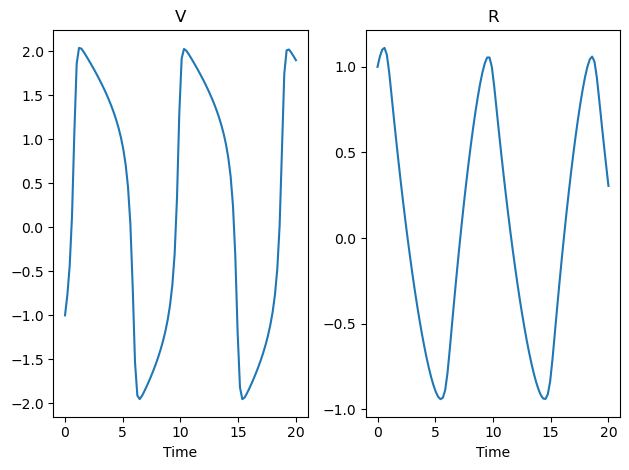

In [7]:
from pygom import common_models

# params
paramEval = [('a',0.2), ('b',0.2), ('c',3.0)]

# set up ode
ode = common_models.FitzHugh(paramEval)

# set time steps
import numpy
t = numpy.linspace(0, 20, 100).astype('float64')

# set initial conditions
x0 = [-1.0, 1.0]
ode.initial_values = (x0, t[0])

# solve and plot
solution = ode.integrate(t[1::])

import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,2, layout='constrained', figsize=(10, 2.5))

axarr[0].plot(t, solution[:,0])
axarr[1].plot(t, solution[:,1]);


## Estimating the parameters

Now we use optimisation algorithms to find the parameters by minimising the loss function.

Let's assume we only know the $R$ state:

In [3]:
from pygom import SquareLoss
import scipy.optimize

theta = [0.5, 0.5, 0.5]  # initial guess for params

objFH = SquareLoss(theta,                        # initial parameter guess
                   ode,                          # PyGOM ode object
                   t0=t[0], x0=x0,               # initial time and conditions
                   t=t[1::], y=solution[1::,1],  # time steps and solution
                   state_name='R')               # name of param in solution

boxBounds = [(0.0,5.0), (0.0,5.0), (0.0,5.0)]  # min and max parameter estimate bounds

res = scipy.optimize.minimize(fun=objFH.cost,
                              jac=objFH.sensitivity, 
                              x0=theta,
                              bounds=boxBounds,
                              method='L-BFGS-B')
print(res)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.38065348108425e-12
        x: [ 2.000e-01  2.000e-01  3.000e+00]
      nit: 18
      jac: [ 1.479e-05  7.406e-08  9.735e-06]
     nfev: 21
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


We see this is a good fit.

## Estimating initial value

We can extend this example to the case where the initial values of $V$ and $R$ are unknown.
We also provide a guesstimate to set off the optimization.
The input vector $\theta$ must have the parameters first, then the initial values, along with the corresponding bounds.
We must also use the `costIV` and `sensitibityIV` options to let the solver know Initial Values.

First, only a single target state, i.e. we only have observations for one of states which is $R$ in this case

In [10]:
objFH = SquareLoss(theta, ode,
                   t0=t[0], x0=x0,
                   t=t[1::], y=solution[1::,1],
                   state_name='R')

boxBounds = [(0.0,5.0), 
             (0.0,5.0),
             (0.0,5.0),
             (None,None),
             (None,None)]

res = scipy.optimize.minimize(fun=objFH.costIV,
                              jac=objFH.sensitivityIV,
                              x0=theta + [-1.0,1.0],
                              bounds=boxBounds, 
                              method='L-BFGS-B')
print(res)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.7339990203493604
        x: [ 0.000e+00  6.052e-01  8.512e-01 -7.159e-01  9.061e-01]
      nit: 20
      jac: [ 4.341e+00  3.166e-04 -2.071e-04 -1.664e-05 -5.012e-05]
     nfev: 25
     njev: 25
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


We see not so good from values and also when we plot: We fit well to the data which we know.

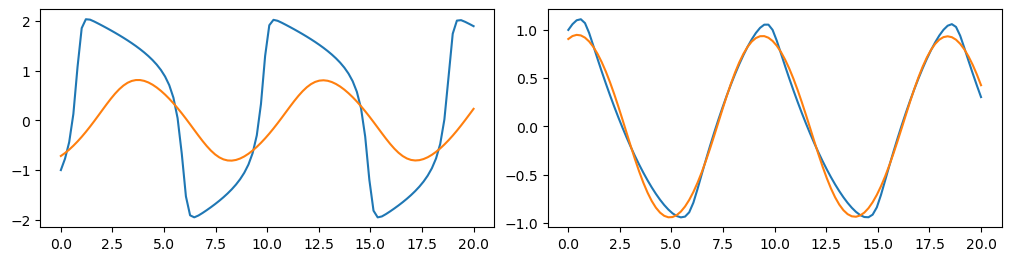

In [14]:
pars=res.x

ode_est = common_models.FitzHugh([('a', pars[0]), ('b', pars[1]), ('c', pars[2])])

x0_est = [pars[3], pars[4]]
ode_est.initial_values = (x0_est, t[0])

solution_est = ode_est.integrate(t[1::])

f, axarr = plt.subplots(1,2, layout='constrained', figsize=(10, 2.5))

axarr[0].plot(t, solution[:,0], color='C0')
axarr[0].plot(t, solution_est[:,0], color='C1')
axarr[1].plot(t, solution[:,1], color='C0')
axarr[1].plot(t, solution_est[:,1], color='C1');

Assume we know both states:

In [6]:
objFH = SquareLoss(theta, ode,
                   t0=t[0], x0=x0,
                   t=t[1::], y=solution[1::,:],
                   state_name=['V','R'])

res = scipy.optimize.minimize(fun=objFH.costIV, 
                              jac=objFH.sensitivityIV, 
                              x0=theta + [-0.5, 0.5],
                              bounds=boxBounds, 
                              method='L-BFGS-B')

print(res)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.9102434290500006e-10
        x: [ 2.000e-01  2.000e-01  3.000e+00 -1.000e+00  1.000e+00]
      nit: 50
      jac: [ 5.228e-04  8.604e-05  2.292e-04 -1.938e-04  1.487e-04]
     nfev: 67
     njev: 67
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [ ]:
pars=res.x

ode_est = common_models.FitzHugh([('a', pars[0]), ('b', pars[1]), ('c', pars[2])])

x0_est = [pars[3], pars[4]]
ode_est.initial_values = (x0_est, t[0])

solution_est = ode_est.integrate(t[1::])

f, axarr = plt.subplots(1,2, layout='constrained', figsize=(10, 2.5))

axarr[0].plot(t, solution[:,0], color='C0')
axarr[0].plot(t, solution_est[:,0], color='C1')
axarr[1].plot(t, solution[:,1], color='C0')
axarr[1].plot(t, solution_est[:,1], color='C1')

See the difference between the two estimates with the latter method; both states
were used, yielding superior estimates.
Note that only the forward
sensitivity method is implemented when estimating the initial value, and
it is assumed that the starting condition for all the states are
unknown.

The choice of algorithm here is the **L-BFGS-B** which is a better
choice because the parameter space of the FitzHugh is rough. This means that the
Hessian is not guaranteed to be positive definite and approximation
using $J^{\top}J$ is poor, with $J$ being the Jacobian of the objective
function.

## Obtaining good initial values for parameters via Function Interpolation

When we want to fit the model to data, one of the necessary steps is to supply the optimization procedure a good set of initial guess for the parameters $\theta$.
This may be a challenge when we do have a good understanding of the process we are trying to model.

A method to obtain such initial guess based on the collocation is available in this package.
A restriction is that data must be present for all states.
Demonstrate with previous example.

Below, we try to find the initial guess without supplying any further
information. The underlying method fits a cubic spline against the
observation and tries to minimize the difference between the first
derivative of the spline and the function of the ode. Varying degree of
smoothness penalty is applied to the spline and the best set of
parameters is the ones that yields the smallest total error, combining
both the fit of the spline against data and the spline against the ode.



In [16]:
from pygom import get_init

theta, sInfo = get_init(solution[1::,:], t[1::], ode, theta=None, full_output=True)

print(theta)

[0.20048258 0.19918548 2.98409032]


In [17]:
print(sInfo)

 message: Solution found.
 success: True
  status: 0
     fun: 0.06821816133192726
       x: 9.734744556902422e-05
     nit: 30
    nfev: 30



As seen above, we have obtained a very good guess of the parameters, in
fact almost the same as the generating process. The information
regarding the smoothing factor shows that the amount of penalty used is
small, which is expected given that we use the solution of the ode as
observations.